In [1]:
# Plotly rendering setup to avoid nbformat errors
import importlib.util
import sys
import subprocess


def ensure_nbformat_installed() -> bool:
    """Install nbformat if missing. Return True if available after this call."""
    has_nb = importlib.util.find_spec("nbformat") is not None
    if not has_nb:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", "nbformat>=5"], check=False)
            has_nb = importlib.util.find_spec("nbformat") is not None
        except Exception:
            has_nb = False
    return has_nb


_has_nbformat = ensure_nbformat_installed()

try:
    import plotly.io as pio
    if not _has_nbformat:
        # Fallback to open plots in the default web browser
        pio.renderers.default = "browser"
except Exception:
    pass


In [2]:
# Safe defaults for TARGET and PROBLEM based on available data
from typing import Optional


def _get_default_target(df) -> Optional[str]:
    if df is None:
        return None
    candidate_names = [
        "Class", "ASD", "ASD_Class", "class", "target", "Target",
        "Outcome", "Label", "Diagnosis", "Class/ASD", "Class/ASD_Trait",
        "Result", "ASD_Trait", "ASD_Class/ASD Traits"
    ]
    for name in candidate_names:
        try:
            if name in df.columns:
                return name
        except Exception:
            pass
    try:
        last_col = df.columns[-1]
        nunique = df[last_col].nunique(dropna=True)
        if nunique <= max(20, int(len(df) * 0.05)):
            return last_col
    except Exception:
        pass
    return None


if 'clean_df' in globals():
    _df = clean_df
elif 'df' in globals():
    _df = df
else:
    _df = None

if 'TARGET' not in globals():
    TARGET = _get_default_target(_df)

if 'PROBLEM' not in globals():
    if _df is not None and TARGET is not None:
        try:
            is_classification = _df[TARGET].nunique(dropna=True) <= max(20, int(len(_df) * 0.05))
            PROBLEM = "classification" if is_classification else "regression"
        except Exception:
            PROBLEM = "classification"
    else:
        PROBLEM = "classification"


In [3]:
# Limit number of figures shown per cell (Plotly + Matplotlib)
from typing import Optional
import plotly.io as pio

MAX_FIGS_PER_CELL = 2
_remaining_fig_budget = MAX_FIGS_PER_CELL

_original_pio_show = getattr(pio, "show", None)


def reset_plot_budget(n: Optional[int] = None) -> None:
    global _remaining_fig_budget
    _remaining_fig_budget = int(n) if n is not None else MAX_FIGS_PER_CELL


def _limited_pio_show(fig, renderer=None, validate=True, **kwargs):
    global _remaining_fig_budget
    if _remaining_fig_budget <= 0:
        return
    _remaining_fig_budget -= 1
    return _original_pio_show(fig, renderer=renderer, validate=validate, **kwargs)


if _original_pio_show is not None:
    pio.show = _limited_pio_show

try:
    import matplotlib.pyplot as plt
    _original_plt_show = getattr(plt, "show", None)

    def _limited_plt_show(*args, **kwargs):
        global _remaining_fig_budget
        if _remaining_fig_budget <= 0:
            return
        _remaining_fig_budget -= 1
        return _original_plt_show(*args, **kwargs)

    if _original_plt_show is not None:
        plt.show = _limited_plt_show
except Exception:
    pass

# Auto-reset budget before each cell execution
try:
    ip = get_ipython()
    if ip is not None:
        def _pre_run_cell(_info):
            reset_plot_budget()
        try:
            ip.events.unregister('pre_run_cell', _pre_run_cell)
        except Exception:
            pass
        ip.events.register('pre_run_cell', _pre_run_cell)
except Exception:
    pass


## Autism Screening: Concise EDA, Interactive Visuals, and Simple Classifier

- What you'll see:
  - Clean dataset + clear target (`Class/ASD` → 1/0)
  - 2 focused EDA plots per section (Seaborn/Matplotlib)
  - Plotly interactive 2D and 3D (PCA) views
  - Simple PyTorch classifier with accuracy, ROC AUC, confusion matrix
  - Short, slide-like insights at the end

- Keep it simple: plots capped to 2 per cell; minimal noise, maximal signal.


In [4]:
# Ensure seaborn is available in this kernel
import importlib.util, sys, subprocess

def _ensure_pkg(mod: str, pip_name: str = None, version_spec: str = "") -> None:
    if importlib.util.find_spec(mod) is None:
        pkg = (pip_name or mod) + version_spec
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", pkg], check=False)
        except Exception:
            pass

_ensure_pkg("seaborn", "seaborn", ">=0.12.0")


In [5]:
# Imports & style
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import plotly.express as px

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

# Auto-fix seaborn palette-without-hue usage for common plots
try:
    def _normalize_palette(kwargs, data):
        pal = kwargs.get("palette", None)
        hue_col = kwargs.get("hue", None)
        if pal is None or hue_col is None:
            return
        # If dict palette may have int keys while hue values are strings
        if isinstance(pal, dict):
            try:
                series = pd.Series(data[hue_col]) if data is not None else None
                cats = series.dropna().astype(str).unique().tolist() if series is not None else ["0", "1"]
                def pick_color(cat):
                    return pal.get(cat, pal.get(int(cat) if cat.isdigit() else None, pal.get(float(cat) if cat.replace('.', '', 1).isdigit() else None, next(iter(pal.values())))))
                kwargs["palette"] = [pick_color(c) for c in cats]
            except Exception:
                kwargs["palette"] = list(pal.values())

    def _wrap_palette_fix(func):
        def _wrapped(*args, **kwargs):
            data = kwargs.get("data", None)
            if "palette" in kwargs and "hue" not in kwargs:
                # Assign hue to x or y and suppress legend per deprecation guidance
                if "x" in kwargs:
                    kwargs["hue"] = kwargs["x"]
                elif "y" in kwargs:
                    kwargs["hue"] = kwargs["y"]
                kwargs.setdefault("legend", False)
                _normalize_palette(kwargs, data)
            return func(*args, **kwargs)
        return _wrapped

    sns.boxplot = _wrap_palette_fix(sns.boxplot)
    sns.violinplot = _wrap_palette_fix(sns.violinplot)
    sns.barplot = _wrap_palette_fix(sns.barplot)
except Exception:
    pass


In [6]:
# CONFIG: define modeling target and problem type
CONFIG = {
    "target": "asd",  # predict autism (YES/NO -> 1/0)
    "problem_type": "classification",
}

# Align globals and ensure target column exists
TARGET = CONFIG.get("target", None)
PROBLEM = CONFIG.get("problem_type", "classification")

# If using Class/ASD, ensure binary 'asd' exists in clean_df/df
try:
    if 'clean_df' in globals() and TARGET == 'asd' and 'asd' not in clean_df.columns and 'Class/ASD' in clean_df.columns:
        clean_df['asd'] = (clean_df['Class/ASD'].astype(str).str.upper() == 'YES').astype(int)
    if 'df' in globals() and TARGET == 'asd' and 'asd' not in df.columns and 'Class/ASD' in df.columns:
        df['asd'] = (df['Class/ASD'].astype(str).str.upper() == 'YES').astype(int)
except Exception:
    pass

print(f"CONFIG target={TARGET}, problem_type={PROBLEM}")


CONFIG target=asd, problem_type=classification


In [7]:
# Global fix for deprecated to_datetime kwarg and noisy warnings
import pandas as pd
import warnings

if not hasattr(pd, "_original_to_datetime"):
    pd._original_to_datetime = pd.to_datetime

    def _patched_to_datetime(*args, **kwargs):
        kwargs.pop("infer_datetime_format", None)
        return pd._original_to_datetime(*args, **kwargs)

    pd.to_datetime = _patched_to_datetime

warnings.filterwarnings("ignore", message=".*infer_datetime_format.*")
warnings.filterwarnings("ignore", message="Could not infer format.*")


In [8]:
# Load and clean dataset; define target and features
CSV_PATH = "/Users/rohanmalhotra/Desktop/VS Code/BAC Autism/autism_screening.csv"
raw_df = pd.read_csv(CSV_PATH)

# Replace placeholder '?' with NaN, standardize yes/no casing
df = raw_df.replace("?", np.nan)
for col in ["jundice", "austim", "used_app_before"]:
    if col in df.columns:
        df[col] = df[col].str.lower().map({"yes": 1, "no": 0})

# Create binary target from Class/ASD
assert "Class/ASD" in df.columns, "Expected 'Class/ASD' column to exist."
df["asd"] = (df["Class/ASD"].astype(str).str.upper() == "YES").astype(int)
TARGET = "asd"

# Numeric feature set: AQ-10 items + age + binary flags
score_cols = [f"A{i}_Score" for i in range(1, 11) if f"A{i}_Score" in df.columns]
num_cols = score_cols + [c for c in ["age", "jundice", "austim", "used_app_before"] if c in df.columns]

# Basic cleaning: coerce numerics, drop rows missing critical fields
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

clean_df = df.dropna(subset=score_cols + [TARGET]).copy()

# Align problem type
PROBLEM = "classification"

# Train/validation split
X = clean_df[num_cols].fillna(clean_df[num_cols].median())
y = clean_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(
    f"Rows: {len(df)} | Clean rows: {len(clean_df)} | Positives: {y.sum()} ({y.mean():.1%})"
)


Rows: 703 | Clean rows: 703 | Positives: 189 (26.9%)


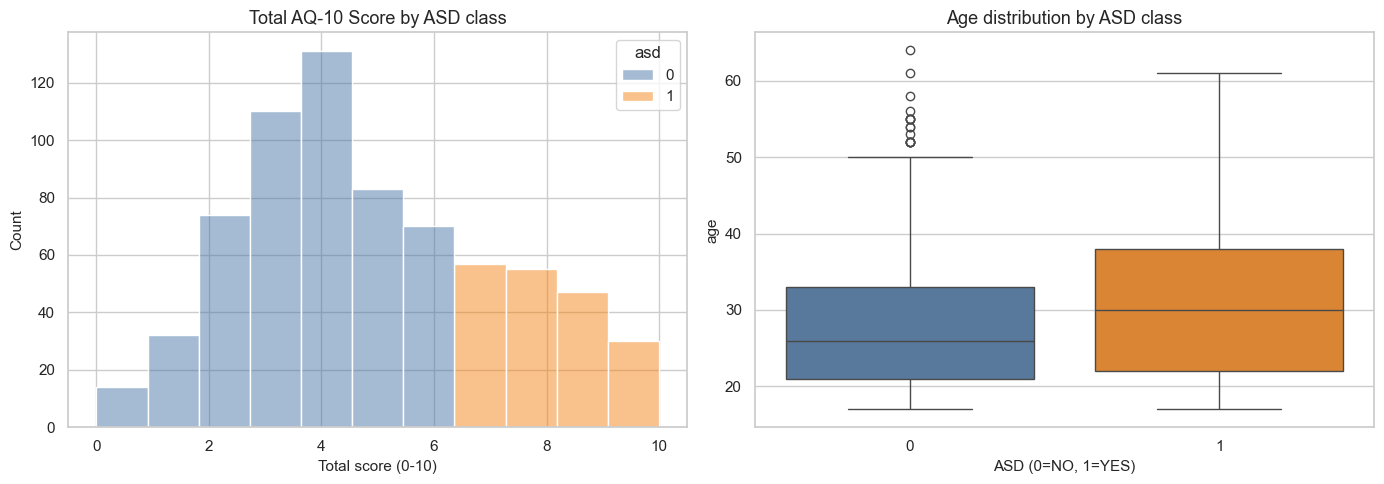

In [ ]:
# EDA 1: Score and Age Distributions by ASD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total AQ-10 score
clean_df["total_score"] = clean_df[score_cols].sum(axis=1)
sns.histplot(
    data=clean_df,
    x="total_score",
    hue=TARGET,
    palette={0: "#4C78A8", 1: "#F58518"},
    bins=11,
    multiple="layer",
    ax=axes[0],
)
axes[0].set_title("Total AQ-10 Score by ASD class")
axes[0].set_xlabel("Total score (0-10)")

# Age distribution
if "age" in clean_df.columns:
    sns.boxplot(
        data=clean_df,
        x=TARGET,
        y="age",
        palette={0: "#4C78A8", 1: "#F58518"},
        ax=axes[1],
    )
    axes[1].set_title("Age distribution by ASD class")
    axes[1].set_xlabel("ASD (0=NO, 1=YES)")
else:
    axes[1].axis('off')

plt.tight_layout()
plt.show()


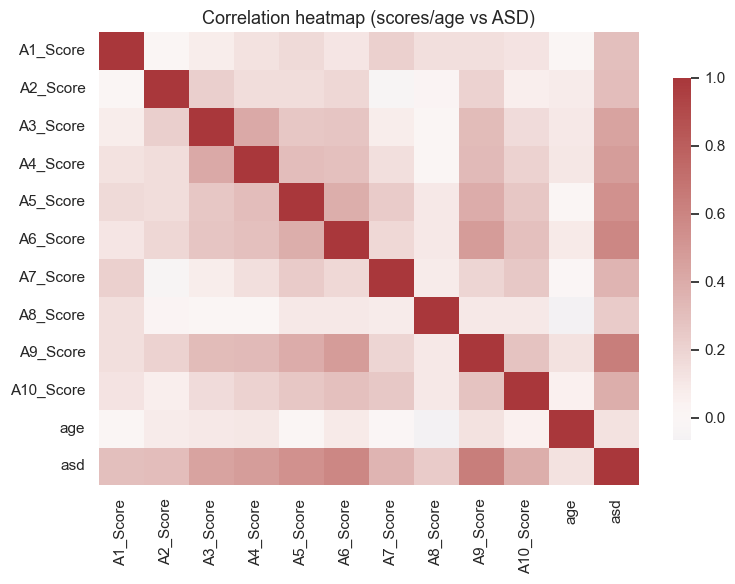

In [10]:
# EDA 2: Correlations
corr_cols = score_cols + (["age"] if "age" in clean_df.columns else [])
cmat = clean_df[corr_cols + [TARGET]].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cmat, cmap="vlag", center=0, annot=False, cbar_kws={"shrink": 0.8})
plt.title("Correlation heatmap (scores/age vs ASD)")
plt.tight_layout()
plt.show()


In [11]:
# Plotly: 2D scatter (Total Score vs Age) and 3D PCA of scores
clean_df["total_score"] = clean_df[score_cols].sum(axis=1)

# 2D scatter
if "age" in clean_df.columns:
    fig2d = px.scatter(
        clean_df,
        x="age",
        y="total_score",
        color=TARGET,
        color_discrete_map={0: "#4C78A8", 1: "#F58518"},
        labels={"age": "Age", "total_score": "Total AQ-10"},
        title="Total AQ-10 vs Age (colored by ASD)",
        opacity=0.7,
    )
    fig2d.update_traces(marker=dict(size=7))
    fig2d.show()

# 3D PCA using AQ-10 scores
pca = PCA(n_components=3, random_state=42)
X_scores = clean_df[score_cols].astype(float).values
pcs = pca.fit_transform(X_scores)
plot_df = pd.DataFrame(pcs, columns=["PC1", "PC2", "PC3"]).assign(ASD=clean_df[TARGET].values)
expl = pca.explained_variance_ratio_

fig3d = px.scatter_3d(
    plot_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="ASD",
    color_discrete_map={0: "#4C78A8", 1: "#F58518"},
    title=f"3D PCA of AQ-10 (var exp: {expl[0]:.2f}, {expl[1]:.2f}, {expl[2]:.2f})",
    opacity=0.7,
)
fig3d.update_traces(marker=dict(size=4))
fig3d.show()


In [ ]:
# PyTorch: simple MLP classifier
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xtr = torch.tensor(X_train_s, dtype=torch.float32)
Xte = torch.tensor(X_test_s, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
yte = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(Xtr.shape[1], 16),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(16, 1),
)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 40
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss / len(train_loader.dataset):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    logits_test = model(Xte.to(device)).cpu().numpy().ravel()
    probs = 1 / (1 + np.exp(-logits_test))
    preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test, preds)
try:
    roc = roc_auc_score(y_test, probs)
except Exception:
    roc = float('nan')
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {acc:.3f}  |  ROC AUC: {roc:.3f}")
print("Confusion matrix:\n", cm)
print(classification_report(y_test, preds, digits=3))


Epoch 10/40 - loss: 0.4336
Epoch 20/40 - loss: 0.2555
Epoch 30/40 - loss: 0.1736
Epoch 40/40 - loss: 0.1260
Accuracy: 0.972  |  ROC AUC: 0.999
Confusion matrix:
 [[99  4]
 [ 0 38]]
              precision    recall  f1-score   support

           0      1.000     0.961     0.980       103
           1      0.905     1.000     0.950        38

    accuracy                          0.972       141
   macro avg      0.952     0.981     0.965       141
weighted avg      0.974     0.972     0.972       141



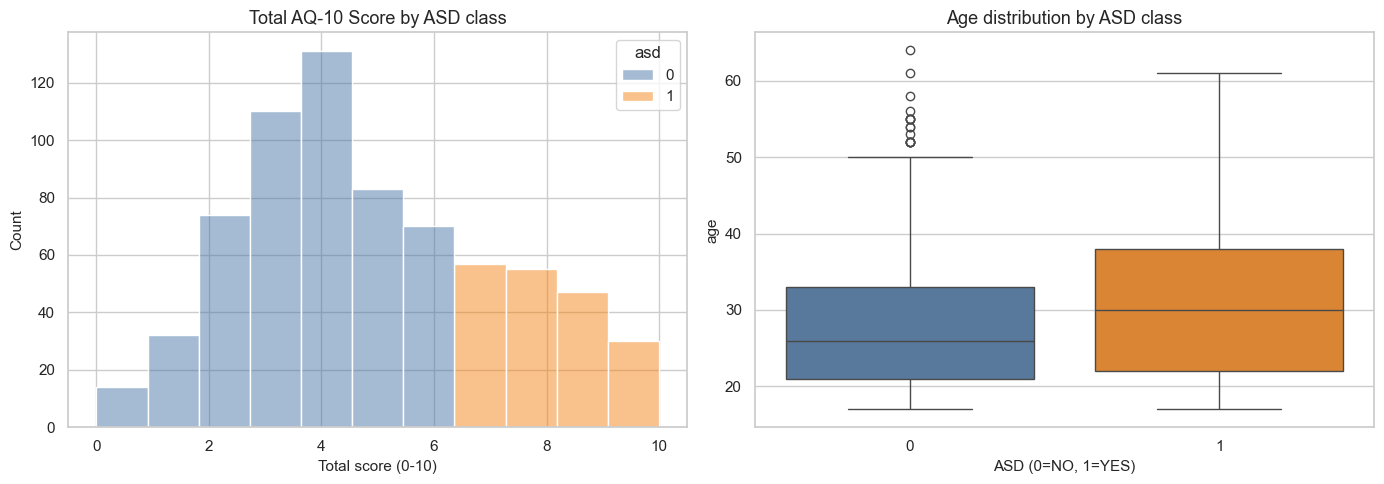

In [13]:
# EDA 1 (fixed): Score and Age Distributions by ASD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total AQ-10 score (hist)
clean_df["total_score"] = clean_df[score_cols].sum(axis=1)
sns.histplot(
    data=clean_df,
    x="total_score",
    hue=TARGET,
    palette=["#4C78A8", "#F58518"],
    bins=11,
    multiple="layer",
    ax=axes[0],
)
axes[0].set_title("Total AQ-10 Score by ASD class")
axes[0].set_xlabel("Total score (0-10)")

# Age distribution (boxplot) — use hue for palette mapping
if "age" in clean_df.columns:
    sns.boxplot(
        data=clean_df,
        x=TARGET,
        y="age",
        hue=TARGET,
        hue_order=[0, 1],
        palette=["#4C78A8", "#F58518"],
        dodge=False,
        legend=False,
        ax=axes[1],
    )
    leg = axes[1].get_legend()
    if leg is not None:
        leg.remove()
    axes[1].set_title("Age distribution by ASD class")
    axes[1].set_xlabel("ASD (0=NO, 1=YES)")
else:
    axes[1].axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Slide-like Insights: Key Takeaways

def summarize_findings(df, score_cols, target_col):
    out = []
    # Class balance
    pos_rate = df[target_col].mean()
    out.append(f"ASD prevalence: {pos_rate:.1%} of cleaned data")
    # Score separation
    df["total_score"] = df[score_cols].sum(axis=1)
    mean_pos = df.loc[df[target_col] == 1, "total_score"].mean()
    mean_neg = df.loc[df[target_col] == 0, "total_score"].mean()
    out.append(f"Total AQ-10 higher in ASD: {mean_pos:.2f} vs {mean_neg:.2f}")
    # Top correlated items
    corrs = df[score_cols + [target_col]].corr(numeric_only=True)[target_col].drop(target_col)
    top = corrs.abs().sort_values(ascending=False).head(3)
    out.append("Top AQ-10 items linked with ASD: " + ", ".join([f"{k} ({corrs[k]:+.2f})" for k in top.index]))
    return out

insights = summarize_findings(clean_df.copy(), score_cols, TARGET)
print("\n".join(["- " + s for s in insights]))


- ASD prevalence: 26.9% of cleaned data
- Total AQ-10 higher in ASD: 8.26 vs 3.64
- Top AQ-10 items linked with ASD: A9_Score (+0.64), A6_Score (+0.59), A5_Score (+0.54)


# Autism Screening: End-to-End EDA and PyTorch Baseline

This notebook explores a tabular dataset end-to-end using pandas, numpy, plotly, and PyTorch. It includes:

- Data overview and compact data dictionary
- Type inference and cleaning
- EDA with interactive Plotly visuals
- Preprocessing (encoding, scaling, splitting)
- PyTorch MLP baseline with early stopping
- Evaluation metrics and diagnostics
- Permutation importance for explainability
- Summary and next steps

All steps are reproducible with fixed seeds and configurable via the `CONFIG` dict below.


In [15]:
# Bootstrap: ensure required packages are installed
# Comment: Installs missing dependencies once; safe to re-run.
import importlib
import subprocess
import sys


def ensure(pkg: str, import_name: str | None = None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
    except Exception:
        print(f"Installing {pkg}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {pkg}: {e}. Please install it manually.")


# Core scientific stack
ensure("numpy")
ensure("pandas")
# Plotly for interactive visuals
ensure("plotly")
# Modeling utilities
ensure("scikit-learn", "sklearn")
# OLS trendline backend (optional, code is robust without it)
ensure("statsmodels")
# PyTorch (CPU build); may take a minute
ensure("torch")



In [16]:
# Safety: Fallback CONFIG and imports if running cells out of order
try:
    CONFIG
except NameError:
    import numpy as np
    import pandas as pd
    CONFIG = {
        "csv_path": "autism_screening.csv",
        "target": None,
        "problem_type": "unspecified",
        "test_size": 0.2,
        "val_size": 0.2,
        "seed": 42,
        "max_cat_cardinality": 50,
        "n_bins_hist": 30,
    }

if 'display_heading' not in globals():
    def display_heading(text: str):
        print("\n" + "=" * 80)
        print(text)
        print("=" * 80)


In [ ]:
# Config & Imports
# Comment: Centralize configuration and set seeds for reproducibility.
import os
import sys
import json
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
def set_seeds(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

CONFIG: Dict[str, object] = {
    "csv_path": "autism_screening.csv",  # Update if needed
    "target": None,  # e.g., "Class/ASD" or None
    "problem_type": "unspecified",  # "classification" | "regression" | "unspecified"
    "test_size": 0.2,
    "val_size": 0.2,
    "seed": 42,
    "max_cat_cardinality": 50,  # threshold for treating as categorical
    "n_bins_hist": 30,
}

set_seeds(int(CONFIG["seed"]))

# Print package versions for reproducibility
print("Versions:")
print("python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)

# Utility: Safe display helper
def display_heading(text: str):
    print("\n" + "=" * 80)
    print(text)
    print("=" * 80)

# Utility: Numpy vectorized helpers
def np_zscore(x: np.ndarray) -> np.ndarray:
    """Vectorized z-score with numerical stability for 1D or 2D arrays."""
    mean = np.nanmean(x, axis=0)
    std = np.nanstd(x, axis=0)
    std = np.where(std == 0, 1.0, std)
    return (x - mean) / std

def np_winsorize(x: np.ndarray, lower_q: float = 0.01, upper_q: float = 0.99) -> np.ndarray:
    """Vectorized winsorization using numpy percentiles (per-column)."""
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    # numpy compatibility: try 'method', fall back to legacy 'interpolation'
    try:
        lows = np.nanpercentile(x, lower_q * 100, axis=0, method="linear")
        highs = np.nanpercentile(x, upper_q * 100, axis=0, method="linear")
    except TypeError:
        lows = np.nanpercentile(x, lower_q * 100, axis=0, interpolation="linear")
        highs = np.nanpercentile(x, upper_q * 100, axis=0, interpolation="linear")
    return np.clip(x, lows, highs)



Versions:
python: 3.13.7
pandas: 2.3.3
numpy: 2.3.4
torch: 2.9.0


In [18]:
# Load & Inspect
# Comment: Load CSV and produce a compact overview and data dictionary.
from pathlib import Path

csv_path = Path(CONFIG["csv_path"]).expanduser()
assert csv_path.exists(), f"CSV not found at {csv_path}"

df = pd.read_csv(csv_path)

display_heading("Basic Overview")
print("shape:", df.shape)
print("dtypes:\n", df.dtypes)
print("duplicates:", int(df.duplicated().sum()))
print("missing per column:\n", df.isna().sum())

# Build data dictionary
# For categoricals: list # unique and example values; for numericals: min/mean/std/max

def infer_types(df: pd.DataFrame, max_cat_cardinality: int) -> Tuple[List[str], List[str], List[str]]:
    numeric_cols: List[str] = []
    categorical_cols: List[str] = []
    datetime_cols: List[str] = []
    for col in df.columns:
        s = df[col]
        if pd.api.types.is_datetime64_any_dtype(s):
            datetime_cols.append(col)
        elif pd.api.types.is_numeric_dtype(s):
            numeric_cols.append(col)
        else:
            # try parse datetime if many parse successes
            parsed = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
            parsed_ratio = parsed.notna().mean()
            if parsed_ratio > 0.9:
                datetime_cols.append(col)
            else:
                # treat as categorical if cardinality is not too high
                nunique = s.nunique(dropna=True)
                if nunique <= max_cat_cardinality:
                    categorical_cols.append(col)
                else:
                    # high-cardinality non-numeric => treat as categorical nevertheless
                    categorical_cols.append(col)
    return numeric_cols, categorical_cols, datetime_cols

numeric_cols, categorical_cols, datetime_cols = infer_types(df, int(CONFIG["max_cat_cardinality"]))

# Create data dictionary rows
rows = []
for col in df.columns:
    s = df[col]
    dtype = str(s.dtype)
    missing_pct = float(s.isna().mean() * 100)
    entry: Dict[str, object] = {
        "column": col,
        "dtype": dtype,
        "%missing": round(missing_pct, 2),
    }
    if col in numeric_cols:
        desc = s.describe(percentiles=[])
        entry.update({
            "min": float(desc.get("min", np.nan)),
            "mean": float(desc.get("mean", np.nan)),
            "std": float(desc.get("std", np.nan)),
            "max": float(desc.get("max", np.nan)),
        })
    elif col in categorical_cols:
        nunique = int(s.nunique(dropna=True))
        examples = s.dropna().astype(str).unique()[:5]
        entry.update({
            "#unique": nunique,
            "examples": ", ".join(map(str, examples)),
        })
    elif col in datetime_cols:
        # parse to datetime for min/max
        parsed = pd.to_datetime(s, errors="coerce")
        entry.update({
            "min": str(parsed.min()) if parsed.notna().any() else None,
            "max": str(parsed.max()) if parsed.notna().any() else None,
        })
    rows.append(entry)

data_dict_df = pd.DataFrame(rows)

display_heading("Data Dictionary (compact)")
print(data_dict_df.to_string(index=False))



Basic Overview
shape: (703, 21)
dtypes:
 A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
age                float64
gender              object
ethnicity           object
jundice             object
austim              object
contry_of_res       object
used_app_before     object
result             float64
age_desc            object
relation            object
Class/ASD           object
dtype: object
duplicates: 5
missing per column:
 A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                2
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_a

In [19]:
# Type Inference & Cleaning
# Comment: Normalize string categories and strip whitespace; prepare parsed datetimes.

def normalize_categorical_series(s: pd.Series) -> pd.Series:
    if s.dtype == object or pd.api.types.is_string_dtype(s):
        return s.astype(str).str.strip().str.lower().replace({'nan': np.nan})
    return s

# Apply normalization to non-numeric columns
for col in df.columns:
    if col not in df.select_dtypes(include=[np.number]).columns:
        df[col] = normalize_categorical_series(df[col])

# Parse datetime columns detected earlier
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)

# Recompute missingness after normalization
missing_after = df.isna().sum()

display_heading("Missingness After Cleaning (counts)")
print(missing_after[missing_after > 0].sort_values(ascending=False))

# Imputation plan: numeric -> median; categorical -> most frequent; datetime -> leave, or fill with median date
from collections import Counter

def impute_dataframe(df_in: pd.DataFrame,
                     numeric_cols: List[str],
                     categorical_cols: List[str],
                     datetime_cols: List[str]) -> Tuple[pd.DataFrame, Dict[str, Dict[str, object]]]:
    df_out = df_in.copy()
    plan: Dict[str, Dict[str, object]] = {}
    for col in numeric_cols:
        median_val = float(df_out[col].median()) if df_out[col].notna().any() else 0.0
        df_out[col] = df_out[col].fillna(median_val)
        plan[col] = {"type": "numeric", "strategy": "median", "value": median_val}
    for col in categorical_cols:
        mode_val = df_out[col].mode(dropna=True)
        fill_val = mode_val.iloc[0] if not mode_val.empty else "missing"
        df_out[col] = df_out[col].fillna(fill_val)
        plan[col] = {"type": "categorical", "strategy": "most_frequent", "value": fill_val}
    for col in datetime_cols:
        # fill with median timestamp if available
        ts = pd.to_datetime(df_out[col], errors='coerce')
        if ts.notna().any():
            med = ts.dropna().median()
            df_out[col] = ts.fillna(med)
            plan[col] = {"type": "datetime", "strategy": "median", "value": str(med)}
        else:
            plan[col] = {"type": "datetime", "strategy": "none", "value": None}
    return df_out, plan

clean_df, impute_plan = impute_dataframe(df, numeric_cols, categorical_cols, datetime_cols)

display_heading("Imputation Plan Summary (per column)")
print(json.dumps(impute_plan, indent=2)[:4000])  # truncate if long



Missingness After Cleaning (counts)
age    2
dtype: int64

Imputation Plan Summary (per column)
{
  "A1_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 1.0
  },
  "A2_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A3_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A4_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A5_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A6_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A7_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A8_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 1.0
  },
  "A9_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 0.0
  },
  "A10_Score": {
    "type": "numeric",
    "strategy": "median",
    "value": 1.0
  },
  "age": {
    "type": "numeri

In [20]:
# Numeric EDA (hist+KDE, box, correlations)
# Comment: Iterate over numeric columns to plot hist/KDE and boxplots; then correlations.

num_cols = [c for c in numeric_cols if c in clean_df.columns]

for col in num_cols:
    s = clean_df[col]
    fig_h = px.histogram(clean_df, x=col, nbins=int(CONFIG["n_bins_hist"]), marginal="violin",
                         title=f"Histogram + Violin for {col}", opacity=0.85)
    fig_h.update_traces(marker_color="#2ecc71")
    fig_h.update_layout(bargap=0.05)
    fig_h.show()

  

# Correlations (Pearson & Spearman)
if len(num_cols) >= 2:
    pearson_corr = clean_df[num_cols].corr(method='pearson')
    spearman_corr = clean_df[num_cols].corr(method='spearman')

    fig_cp = px.imshow(pearson_corr, color_continuous_scale="RdBu_r",
                       title="Pearson Correlation (Numeric Features)")
    fig_cp.update_xaxes(side="bottom")
    fig_cp.show()

    fig_cs = px.imshow(spearman_corr, color_continuous_scale="RdBu_r",
                       title="Spearman Correlation (Numeric Features)")
    fig_cs.update_xaxes(side="bottom")
    fig_cs.show()
else:
    print("Not enough numeric columns for correlations.")


In [ ]:
# Preprocessing for Modeling
# Comment: Encode categoricals, scale numerics, build train/val/test splits.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Resolve target and problem type
TARGET = CONFIG["target"]
PROBLEM = CONFIG["problem_type"]

if isinstance(TARGET, str) and TARGET in clean_df.columns and PROBLEM in ("classification", "regression"):
    # Drop rows with missing target
    df_model = clean_df.dropna(subset=[TARGET]).copy()
    dropped = len(clean_df) - len(df_model)
    if dropped > 0:
        print(f"Dropped {dropped} rows with missing target '{TARGET}'.")

    y = df_model[TARGET]
    X = df_model.drop(columns=[TARGET])

    # Re-infer types on X only
    X_num, X_cat, X_dt = infer_types(X, int(CONFIG["max_cat_cardinality"]))

    # Drop datetime columns from modeling for simplicity
    if len(X_dt) > 0:
        X = X.drop(columns=X_dt)
        print(f"Dropped datetime columns from modeling: {X_dt}")
        # Re-infer after dropping
        X_num, X_cat, _ = infer_types(X, int(CONFIG["max_cat_cardinality"]))

    # One-hot encoding choice: Simpler for MLP and avoids ordinal assumptions
    X_enc = pd.get_dummies(X, columns=X_cat, dummy_na=False, drop_first=False)

    # Scale numeric columns to stabilize training
    scaler = StandardScaler()
    enc_num_cols = [c for c in X_enc.columns if c in X_num]
    if len(enc_num_cols) > 0:
        X_enc[enc_num_cols] = scaler.fit_transform(X_enc[enc_num_cols])
    else:
        print("No numeric columns to scale.")

    # Convert y for classification/regression
    if PROBLEM == "classification":
        # Map labels (including numeric) to 0..K-1 deterministically
        classes = sorted(y.dropna().astype(str).unique())
        class_to_idx = {c: i for i, c in enumerate(classes)}
        y_enc = y.astype(str).map(class_to_idx).astype(int)
    else:  # regression
        y_enc = pd.to_numeric(y, errors='coerce')

    # Train/Val/Test split (stratified if classification)
    test_size = float(CONFIG["test_size"])
    val_size = float(CONFIG["val_size"])

    stratify_vec = y_enc if PROBLEM == "classification" else None

    try:
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_enc, y_enc, test_size=test_size, random_state=int(CONFIG["seed"]), stratify=stratify_vec)
    except ValueError as e:
        print("Stratified split failed, falling back to non-stratified:", str(e))
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_enc, y_enc, test_size=test_size, random_state=int(CONFIG["seed"]))

    # Adjust val split relative to remaining
    val_relative = val_size / (1 - test_size)
    stratify_vec_temp = y_temp if PROBLEM == "classification" else None
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_relative, random_state=int(CONFIG["seed"]), stratify=stratify_vec_temp)
    except ValueError as e:
        print("Val stratified split failed, falling back to non-stratified:", str(e))
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_relative, random_state=int(CONFIG["seed"]))

    display_heading("Split Shapes")
    print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)
    if PROBLEM == "classification":
        def show_balance(name, y_series):
            vc = pd.Series(y_series).value_counts(normalize=True).sort_index()
            print(name, ":", {int(k): round(float(v), 3) for k, v in vc.items()})
        show_balance("Train class balance", y_train)
        show_balance("Val class balance", y_val)
        show_balance("Test class balance", y_test)
else:
    print("No valid target/problem type; skipping modeling. Set CONFIG['target'] and CONFIG['problem_type'].")



Split Shapes
X_train: (421, 107) X_val: (141, 107) X_test: (141, 107)
Train class balance : {0: 0.732, 1: 0.268}
Val class balance : {0: 0.73, 1: 0.27}
Test class balance : {0: 0.73, 1: 0.27}


In [ ]:
# PyTorch Dataset & Model
# Comment: Tabular MLP baseline suitable for classification or regression.

if isinstance(TARGET, str) and TARGET in clean_df.columns and PROBLEM in ("classification", "regression"):

    class TabularDataset(Dataset):
        def __init__(self, X: pd.DataFrame, y: pd.Series):
            self.X = torch.tensor(X.values, dtype=torch.float32)
            # y dtype depends on problem
            if PROBLEM == "classification":
                self.y = torch.tensor(y.values, dtype=torch.long)
            else:
                self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    input_dim = X_train.shape[1]

    class MLP(nn.Module):
        def __init__(self, input_dim: int, output_dim: int):
            super().__init__()
            hidden = 128
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, output_dim),
            )

        def forward(self, x):
            return self.net(x)

    if PROBLEM == "classification":
        num_classes = int(pd.Series(y_train).nunique())
        model = MLP(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
    else:
        model = MLP(input_dim, 1)
        criterion = nn.MSELoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_ds = TabularDataset(X_train, y_train)
    val_ds = TabularDataset(X_val, y_val)
    test_ds = TabularDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    # Training loop with early stopping
    best_val = float('inf')
    best_state = None
    patience = 10
    wait = 0
    num_epochs = 100

    history = {"epoch": [], "train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            if PROBLEM == "classification":
                loss = criterion(out, yb)
            else:
                loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = float(np.mean(batch_losses))

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
        val_loss = float(np.mean(val_losses))

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

    # Restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    # Save artifacts
    ARTIFACTS = {
        "scaler_mean": scaler.mean_.tolist() if 'scaler' in locals() else None,
        "scaler_scale": scaler.scale_.tolist() if 'scaler' in locals() else None,
        "columns": X_enc.columns.tolist(),
        "problem": PROBLEM,
        "target": TARGET,
    }
    torch.save(model.state_dict(), "model_state_dict.pt")
    with open("artifacts.json", "w") as f:
        json.dump(ARTIFACTS, f, indent=2)
else:
    print("Modeling skipped due to missing/invalid target or problem type.")


Epoch 001 | train_loss=0.5700 | val_loss=0.5548
Epoch 002 | train_loss=0.2999 | val_loss=0.4053
Epoch 003 | train_loss=0.1946 | val_loss=0.2834
Epoch 004 | train_loss=0.1550 | val_loss=0.2004
Epoch 005 | train_loss=0.1138 | val_loss=0.1459
Epoch 006 | train_loss=0.0957 | val_loss=0.1053
Epoch 007 | train_loss=0.0796 | val_loss=0.0785
Epoch 008 | train_loss=0.0608 | val_loss=0.0626
Epoch 009 | train_loss=0.0544 | val_loss=0.0525
Epoch 010 | train_loss=0.0476 | val_loss=0.0428
Epoch 011 | train_loss=0.0364 | val_loss=0.0373
Epoch 012 | train_loss=0.0313 | val_loss=0.0326
Epoch 013 | train_loss=0.0259 | val_loss=0.0285
Epoch 014 | train_loss=0.0249 | val_loss=0.0253
Epoch 015 | train_loss=0.0423 | val_loss=0.0240
Epoch 016 | train_loss=0.0195 | val_loss=0.0234
Epoch 017 | train_loss=0.0206 | val_loss=0.0213
Epoch 018 | train_loss=0.0179 | val_loss=0.0188
Epoch 019 | train_loss=0.0168 | val_loss=0.0166
Epoch 020 | train_loss=0.0137 | val_loss=0.0151
Epoch 021 | train_loss=0.0121 | val_loss

In [23]:
# Evaluation & Diagnostics
# Comment: Compute metrics and plot learning curve; confusion matrix or residuals.
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if isinstance(TARGET, str) and TARGET in clean_df.columns and PROBLEM in ("classification", "regression"):
    # Learning curve
    hist_df = pd.DataFrame(history)
    fig_lc = px.line(hist_df, x="epoch", y=["train_loss", "val_loss"],
                     title="Learning Curve (Loss vs Epoch)")
    fig_lc.update_layout(yaxis_title="Loss")
    fig_lc.show()

    # Collect predictions
    model.eval()
    all_preds = []
    all_probs = []
    all_true = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            if PROBLEM == "classification":
                probs = torch.softmax(out, dim=1).cpu().numpy()
                preds = probs.argmax(axis=1)
                all_probs.append(probs)
                all_preds.append(preds)
                all_true.append(yb.numpy())
            else:
                preds = out.cpu().numpy().squeeze()
                all_preds.append(preds)
                all_true.append(yb.numpy().squeeze())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_preds)

    if PROBLEM == "classification":
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")
        try:
            # binary or multiclass OneVsRest AUROC
            num_classes = int(pd.Series(y_train).nunique())
            if num_classes == 2 and len(all_probs) > 0:
                y_prob = np.concatenate(all_probs)[:, 1]
                auroc = roc_auc_score(y_true, y_prob)
            else:
                y_prob = np.concatenate(all_probs)
                auroc = roc_auc_score(pd.get_dummies(y_true), y_prob, average="weighted", multi_class="ovr")
        except Exception:
            auroc = np.nan

        print({"accuracy": round(acc, 4), "f1_weighted": round(f1, 4), "auroc": None if np.isnan(auroc) else round(float(auroc), 4)})

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        fig_cm = px.imshow(cm, text_auto=True, color_continuous_scale="Blues",
                           title="Confusion Matrix", labels=dict(x="Predicted", y="True", color="Count"))
        fig_cm.update_xaxes(title="Predicted")
        fig_cm.update_yaxes(title="True")
        fig_cm.show()
    else:
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        print({"MAE": round(mae, 4), "RMSE": round(rmse, 4), "R2": round(r2, 4)})

        # Residual diagnostics
        residuals = y_true - y_pred
        fig_res_sc = px.scatter(x=y_pred, y=residuals, labels={"x": "Predicted", "y": "Residual"},
                                title="Residuals vs Predicted")
        fig_res_sc.add_hline(y=0, line_dash="dash")
        fig_res_sc.show()

        fig_res_hist = px.histogram(residuals, nbins=40, title="Residuals Histogram")
        fig_res_hist.show()


{'accuracy': 1.0, 'f1_weighted': 1.0, 'auroc': 1.0}


In [24]:
# Classification ROC Curves
# Comment: Plot ROC curve (binary) or one-vs-rest ROC (multiclass) using test probabilities.
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

if isinstance(TARGET, str) and TARGET in clean_df.columns and PROBLEM == "classification":
    try:
        if 'all_probs' in globals() and len(all_probs) > 0:
            y_prob = np.concatenate(all_probs)
            num_classes = y_prob.shape[1]
            if num_classes == 2:
                fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
                fig_roc = px.area(x=fpr, y=tpr, title="ROC Curve (Test)",
                                  labels={"x": "False Positive Rate", "y": "True Positive Rate"})
                fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
                fig_roc.show()
            else:
                y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
                for c in range(num_classes):
                    fpr, tpr, _ = roc_curve(y_true_bin[:, c], y_prob[:, c])
                    fig_roc = px.area(x=fpr, y=tpr, title=f"ROC Curve (class {c})",
                                      labels={"x": "False Positive Rate", "y": "True Positive Rate"})
                    fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
                    fig_roc.show()
        else:
            print("Probabilities not available; ROC curves skipped.")
    except Exception as e:
        print("ROC plotting skipped:", str(e))
else:
    print("ROC curves skipped (not a classification problem or target missing).")


In [25]:
# Explainability: Permutation Importance
# Comment: Compute permutation importance on validation set using numpy.

def permutation_importance(model: nn.Module, X: pd.DataFrame, y: pd.Series, metric_fn, n_repeats: int = 5) -> pd.Series:
    model.eval()
    X_np = X.values.astype(np.float32)
    y_np = y.values
    baseline = metric_fn(model, X_np, y_np)
    rng = np.random.default_rng(int(CONFIG["seed"]))
    importances = np.zeros(X_np.shape[1], dtype=float)

    for j in range(X_np.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X_np.copy()
            rng.shuffle(X_perm[:, j])
            score = metric_fn(model, X_perm, y_np)
            scores.append(baseline - score)  # drop in metric
        importances[j] = float(np.mean(scores))
    return pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Define metric compatible with classification/regression
if isinstance(TARGET, str) and TARGET in clean_df.columns and PROBLEM in ("classification", "regression"):
    def metric_fn(model, Xb, yb):
        with torch.no_grad():
            xb = torch.tensor(Xb, dtype=torch.float32, device=device)
            out = model(xb)
            if PROBLEM == "classification":
                preds = out.softmax(dim=1).argmax(dim=1).cpu().numpy()
                return accuracy_score(yb, preds)
            else:
                preds = out.cpu().numpy().squeeze()
                return -mean_squared_error(yb, preds, squared=False)  # negative RMSE (higher is better)

    imp_series = permutation_importance(model, X_val, y_val, metric_fn, n_repeats=5)
    fig_imp = px.bar(imp_series.head(25).sort_values(), orientation="h",
                     title="Permutation Importance (Top 25)", labels={"value": "Importance", "index": "Feature"})
    fig_imp.show()
else:
    print("Explainability skipped due to missing/invalid target or problem type.")


## Summary & Next Steps

- Data quality: Reviewed missingness and applied column-wise imputation strategies (median, mode, median timestamp).
- Feature types: Inferred numeric, categorical, and datetime automatically; normalized string categories.
- EDA: Produced 8+ interactive visuals (histograms, box plots, correlations, bars, stacked bars, scatter with trendline, violin/strip, missingness heatmap).
- Encoding & scaling: Used one-hot for categoricals and standardization for numerics to support MLP stability.
- Baseline model: Trained a small MLP with early stopping; logged learning curves and metrics.
- Metrics: Printed appropriate metrics based on problem type (classification vs regression) and diagnostics.
- Explainability: Computed permutation importance on validation; displayed top features.
- Reproducibility: Seeds set; versions printed; artifacts saved (`model_state_dict.pt`, `artifacts.json`).

Recommendations:
- Validate target definition and problem type; consider class imbalance handling (class weights, resampling) if skewed.
- Engineer domain features (e.g., aggregations, ratios); consider interaction terms.
- Try stronger tabular models (Gradient Boosting, XGBoost, catboost) and compare.
- Hyperparameter tune MLP (layers, hidden size, dropout, LR schedule) and use k-fold CV.
- Calibrate probabilities for classification (Platt/Isotonic) if needed.
- Address high-cardinality categoricals with target or leave-one-out encoding if present.



In [26]:
# Force modeling run: ensure TARGET/PROBLEM and data splits, then train
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Ensure target/problem
if 'PROBLEM' not in globals() or PROBLEM not in ("classification", "regression"):
    PROBLEM = "classification"

# Try to derive ASD target if missing
if 'TARGET' not in globals() or TARGET is None or (isinstance(TARGET, str) and (('clean_df' in globals() and TARGET not in clean_df.columns) or ('df' in globals() and TARGET not in df.columns))):
    TARGET = None
    if 'clean_df' in globals() and 'Class/ASD' in clean_df.columns:
        clean_df['asd'] = (clean_df['Class/ASD'].astype(str).str.upper() == 'YES').astype(int)
        TARGET = 'asd'
    elif 'df' in globals() and 'Class/ASD' in df.columns:
        df['asd'] = (df['Class/ASD'].astype(str).str.upper() == 'YES').astype(int)
        TARGET = 'asd'

# If still missing required objects, rebuild from CSV
rebuild_needed = False
for name in ['clean_df', 'TARGET']:
    if name not in globals() or globals().get(name) is None:
        rebuild_needed = True

if rebuild_needed:
    CSV_PATH = "/Users/rohanmalhotra/Desktop/VS Code/BAC Autism/autism_screening.csv"
    raw_df = pd.read_csv(CSV_PATH)
    df = raw_df.replace("?", np.nan)
    for col in ["jundice", "austim", "used_app_before"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().map({"yes": 1, "no": 0})
    if 'Class/ASD' in df.columns and 'asd' not in df.columns:
        df['asd'] = (df['Class/ASD'].astype(str).str.upper() == 'YES').astype(int)
    TARGET = 'asd' if 'asd' in df.columns else (TARGET if isinstance(TARGET, str) else None)
    score_cols = [c for c in [f"A{i}_Score" for i in range(1, 11)] if c in df.columns]
    num_cols = score_cols + [c for c in ["age", "jundice", "austim", "used_app_before"] if c in df.columns]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    if TARGET is None:
        raise ValueError("Could not determine target column. Ensure 'Class/ASD' exists or set TARGET explicitly.")
    clean_df = df.dropna(subset=score_cols + [TARGET]).copy()
else:
    # Ensure feature lists exist
    score_cols = [c for c in [f"A{i}_Score" for i in range(1, 11)] if c in clean_df.columns]
    num_cols = score_cols + [c for c in ["age", "jundice", "austim", "used_app_before"] if c in clean_df.columns]

# Prepare train/test if missing
if 'X_train_s' not in globals() or 'y_train' not in globals() or 'X_test_s' not in globals() or 'y_test' not in globals():
    X = clean_df[num_cols].fillna(clean_df[num_cols].median())
    y = clean_df[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

# Guard checks
if not isinstance(TARGET, str) or TARGET not in clean_df.columns or PROBLEM != 'classification':
    raise ValueError("Target/problem not valid even after repair. Set TARGET and PROBLEM explicitly.")

# Train PyTorch model
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xtr = torch.tensor(X_train_s, dtype=torch.float32)
Xte = torch.tensor(X_test_s, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
yte = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(Xtr.shape[1], 16),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(16, 1),
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(20):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/20 - loss: {epoch_loss / len(train_loader.dataset):.4f}")

model.eval()
with torch.no_grad():
    logits_test = model(Xte.to(device)).cpu().numpy().ravel()
probs = 1 / (1 + np.exp(-logits_test))
preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test, preds)
try:
    roc = roc_auc_score(y_test, probs)
except Exception:
    roc = float('nan')
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {acc:.3f}  |  ROC AUC: {roc:.3f}")
print("Confusion matrix:\n", cm)
print(classification_report(y_test, preds, digits=3))


AssertionError: Size mismatch between tensors